In [1]:
write_images = False


wirte_output_txt = False 
# Specify everytime Simulation is called 
# WARNING --> Set to False when running more then 10 simulations 
#            (otherwise it will be super slow and might crash)

In [2]:
import numpy as np

In [3]:
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

import matplotlib.pyplot as plt
import mlai.plot as plot

In [4]:
%run Missile_utils.ipynb

In [5]:
simulation_output = 'range' # For now only this is implemented
# We divide by 1000 to avoid dealing with too large numbers

In [6]:
run_grid_simulation = True # If true takes much longer and does 3D plots and so on for MODEL with 2 FEATS


We consider missiles with only 1 stage

In [7]:

basic_param_spaces = {
    'payload':  [10, 2410],
    'missilediam':  [0.1, 9.9],
    'rvdiam':  [0.1, 9.9],
    'estrange': [100, 4900], 
    'fuelmass': [500, 6000], # [500, 7000], 
    'drymass':  [1000, 3000],
    'Isp0':  [100, 800],# [100, 800],
    'thrust0':  [10000, 69000],
}

In [8]:
from sklearn.metrics import mean_squared_error
import math

# TODO: improve considering also the variance 
# (i.e. penalise less if mean prediction is not accurate, but still within 2 std dev?)
def compute_rmse(y_actual, y_predicted):
    MSE = mean_squared_error(y_actual, y_predicted)
    RMSE = math.sqrt(MSE)
 
    return RMSE

def evaluate_prediction(y_actual, y_predicted):
    return compute_rmse(y_actual, y_predicted)
    
    

# 1. Two params

In [9]:
m2_param_1 = 'fuelmass'
m2_domain_param_1 = basic_param_spaces[m2_param_1] # [500, 6000] # [5000,15000]
m2_param_2 = 'Isp0'
m2_domain_param_2 = basic_param_spaces[m2_param_2] # [200, 300] # [224, 228]

m2_space = ParameterSpace(
          [ContinuousParameter(m2_param_1, *m2_domain_param_1), 
           ContinuousParameter(m2_param_2, *m2_domain_param_2),
#            ContinuousParameter(param_3, *domain_param_3),
#            ContinuousParameter(param_4, *domain_param_4)
          ])

custom_param_names = [m2_param_1, m2_param_2]

In [10]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION (Re-run since custom_param_names has changed)
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
                
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


## 1. Experimental design

Experimental design addresses the problem of how to collect data points (experiments) to better control certain sources of variance of a model.

In experimental design the goal is to decide at which locations of the input space we should evaluate a function of interest. In some contexts it is also known as active learning, for instance in image classification problems in which more labels need to be collected.

The are two main ways of doing experimental design.

1. Model-free designs: These designs define rules to spread the experiments as much as possible across the input domain. Drawing points at random or in a grid are the most naive way of doing so. Other more elaborate approaches are low discrepancy sequences that try to induce some negative correlation in the selected points to spread them evenly. Some examples are Latin hyper-cube sampling and Sobol sequences.

2. Model-based designs: In these designs a feedback loop is used between some ‘optimal’ statistical criterion to collect points and a model. In general, the criterion aims to reduce some type of variance in the model. The type of optimality refers to which type of uncertainty that is reduced. For instance, a D-optimal design aims to maximize the differential Shannon information content of the model parameter estimates; an I-optimal design seeks to minimize the average prediction variance over the entire design space. 

Gaussian processes have a long tradition of being the ‘model of choice’ for designing experiments.

### Use model-free experimental design to start
 (RandomDesign or Latin Design)


New simulation 

fuelmass: 4526.483571703127
Isp0: 637.2546113928842


Stage 1 burnout
Velocity (km/s):  6.451481066911585
Angle (deg h):  43.65187872295063
Range (km):  331.428951238325
Time (sec):  314.30000000000297
Final results: 
Range (km):  7485.038957672333
Apogee (km):  2858.7301890132476
Time to target (sec):  2704.6999999986356




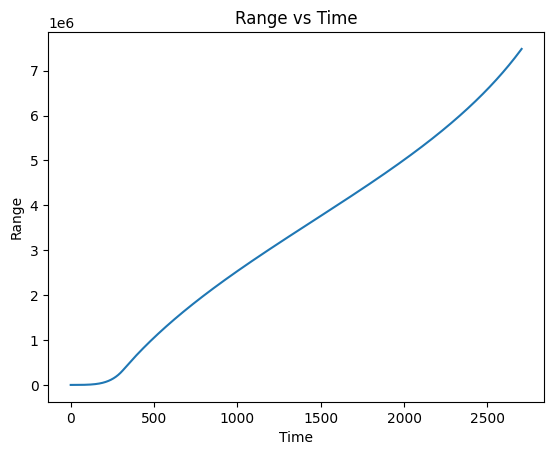

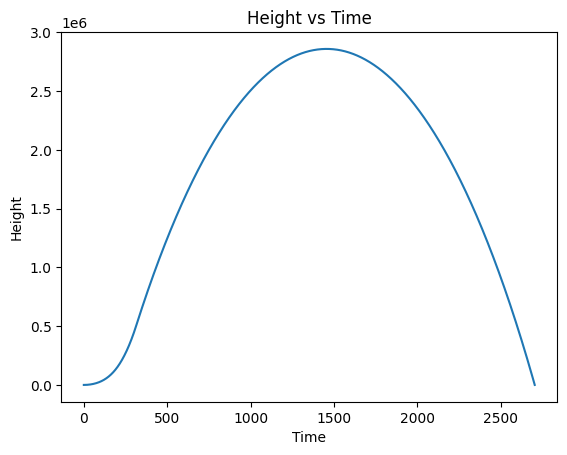

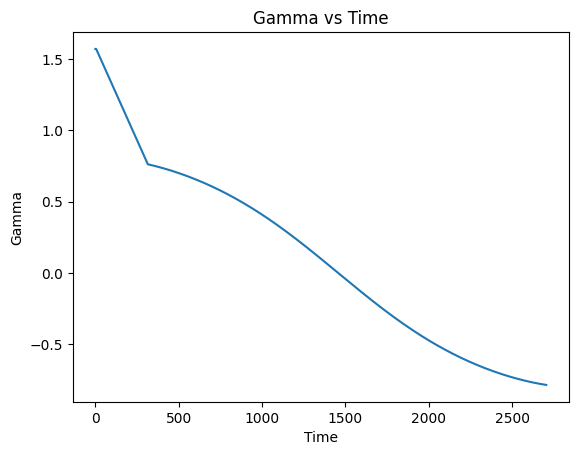

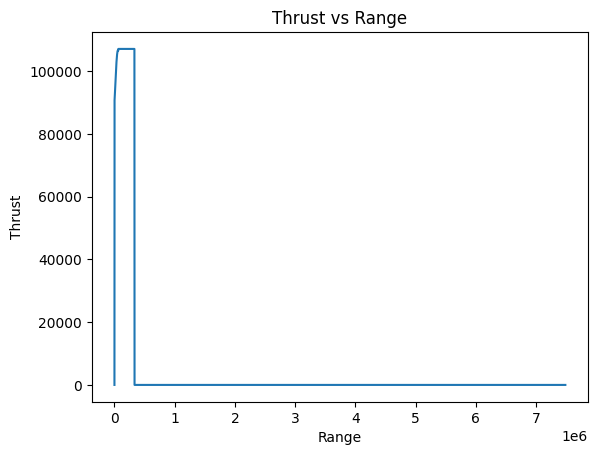

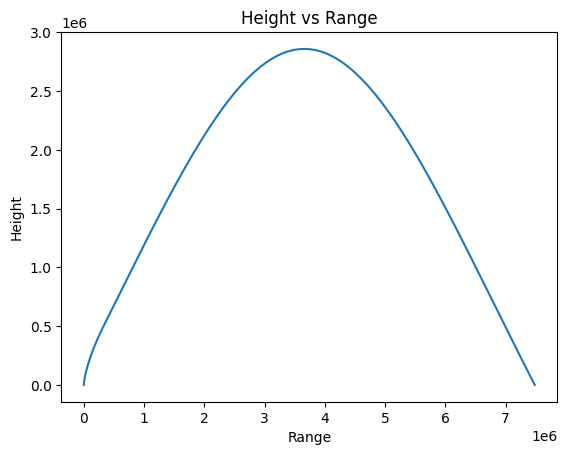

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 2763.8772820634226
Isp0: 180.14202828164514


Stage 1 burnout
Velocity (km/s):  1.0938190395655172
Angle (deg h):  43.66324678776863
Range (km):  11.723861190307833
Time (sec):  54.3000000000005
Final results: 
Range (km):  153.00816044817498
Apogee (km):  49.07867849460461
Time to target (sec):  234.29999999999097




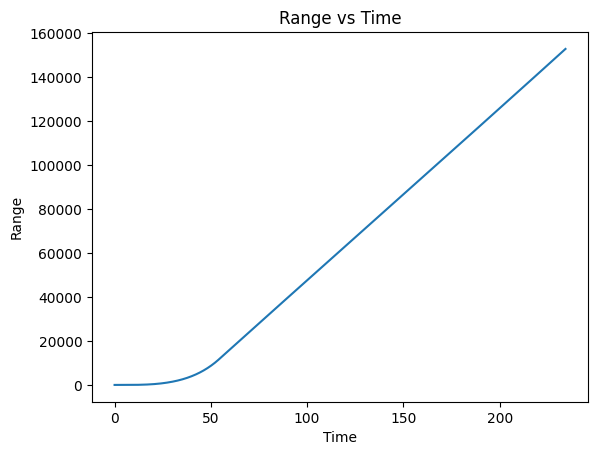

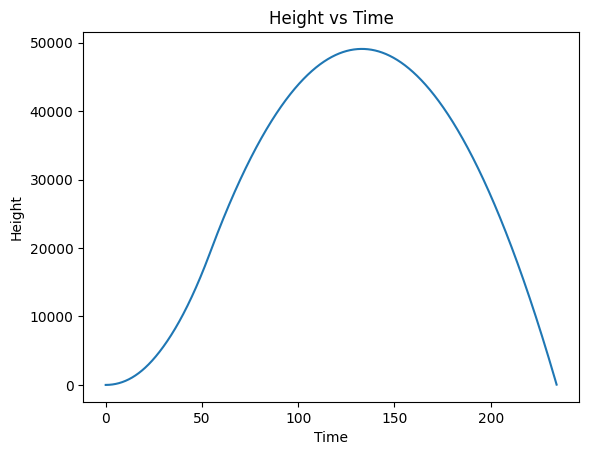

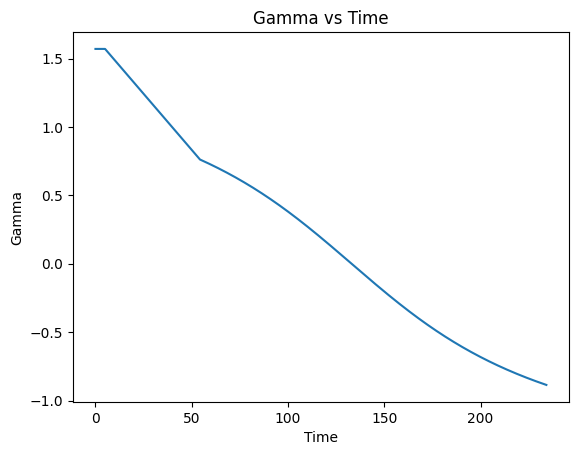

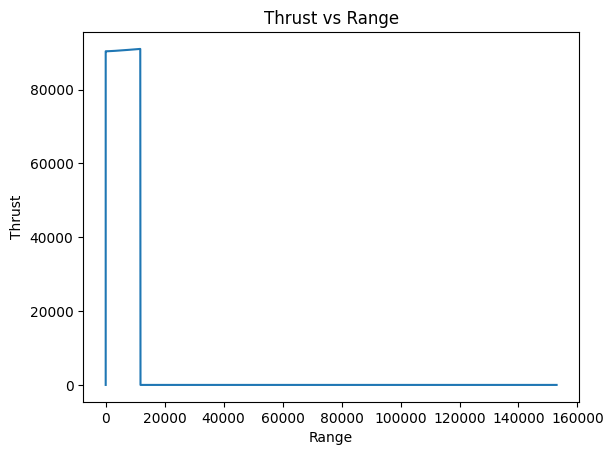

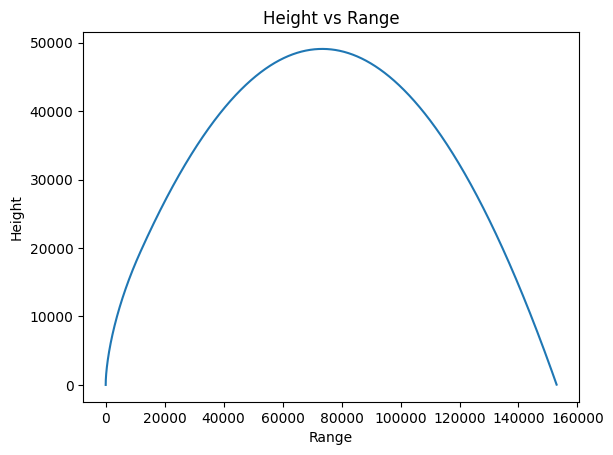

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 2482.947456250864
Isp0: 233.58315258518556


Stage 1 burnout
Velocity (km/s):  1.3764873549806786
Angle (deg h):  43.6988222754873
Range (km):  17.155785008373613
Time (sec):  63.20000000000063
Final results: 
Range (km):  240.31564944999886
Apogee (km):  75.87281279278294
Time to target (sec):  290.2999999999975




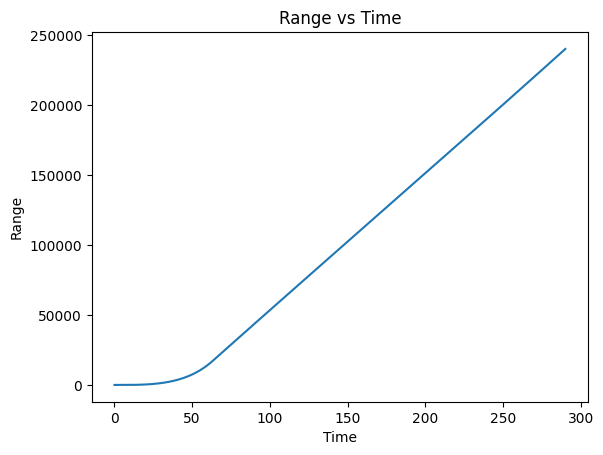

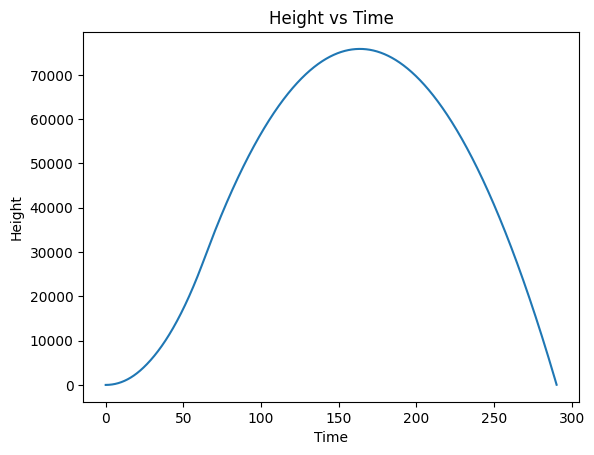

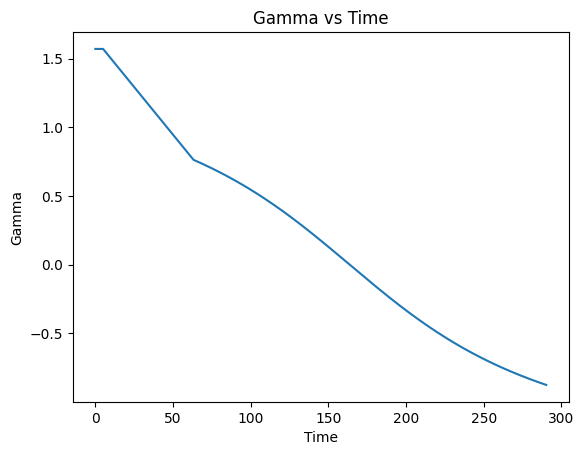

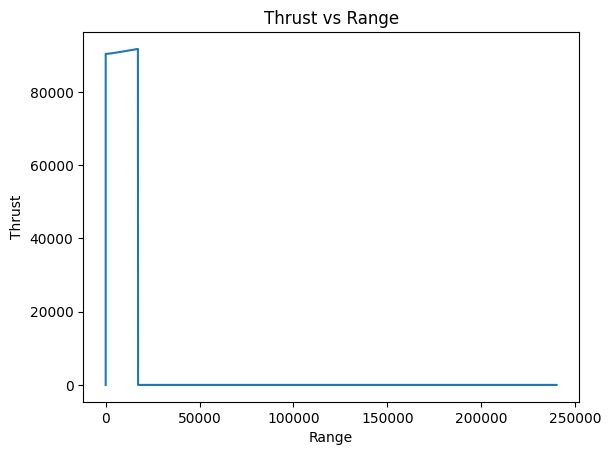

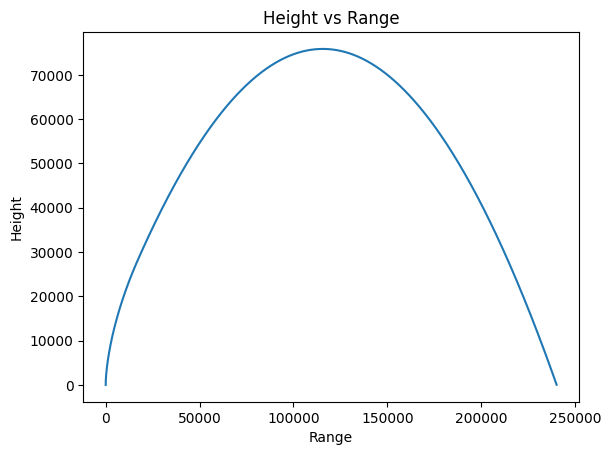

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 600.907702897602
Isp0: 773.0267126803083


Stage 1 burnout
Velocity (km/s):  1.637323370951346
Angle (deg h):  43.6664462739646
Range (km):  18.20819090271941
Time (sec):  50.60000000000045
Final results: 
Range (km):  329.3714932953628
Apogee (km):  100.12360028991101
Time to target (sec):  317.9000000000038




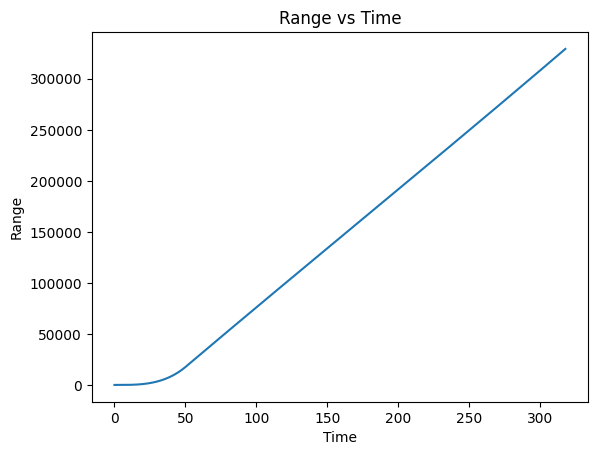

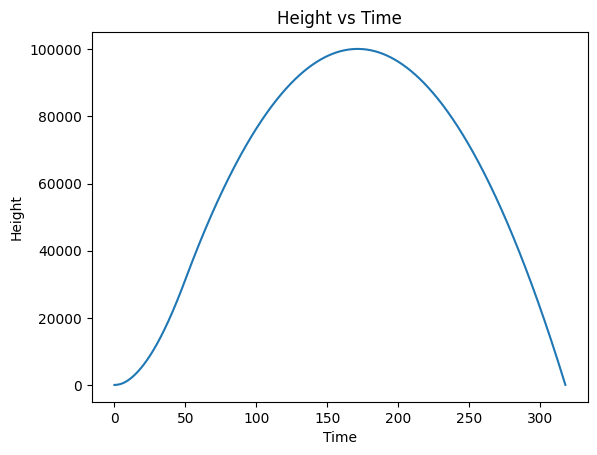

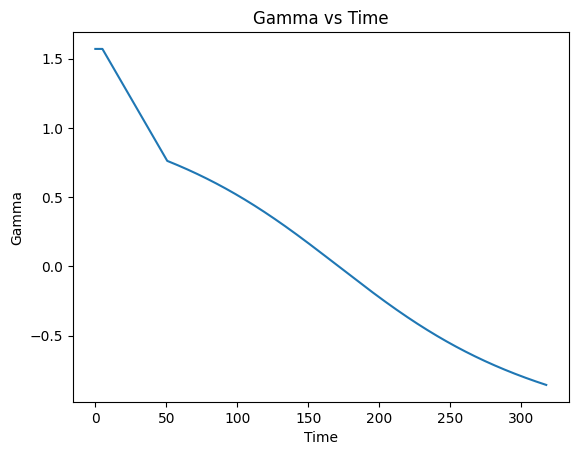

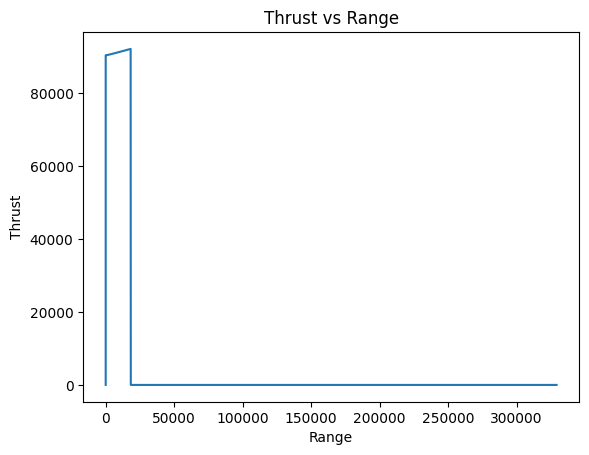

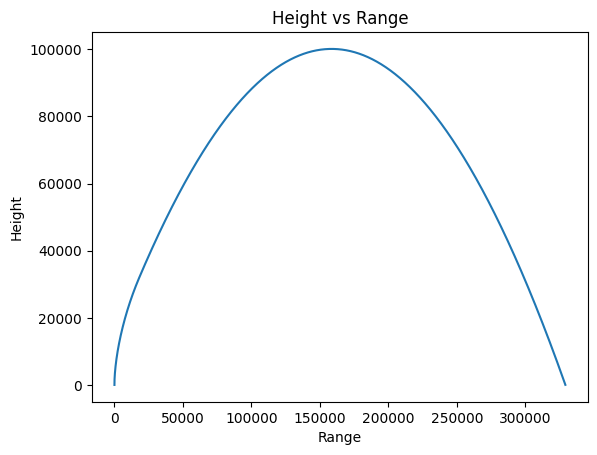

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 3175.7382852572973
Isp0: 562.3808763820041


Stage 1 burnout
Velocity (km/s):  4.6524794418926145
Angle (deg h):  43.652202619139985
Range (km):  162.4744785746836
Time (sec):  194.59999999999323
Final results: 
Range (km):  3185.169842875669
Apogee (km):  1024.2186477540688
Time to target (sec):  1261.699999999948




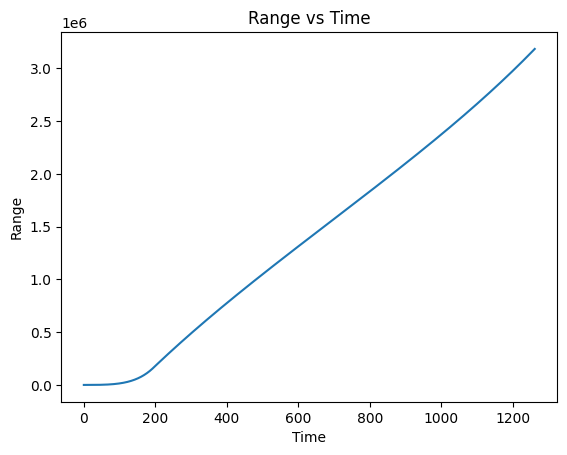

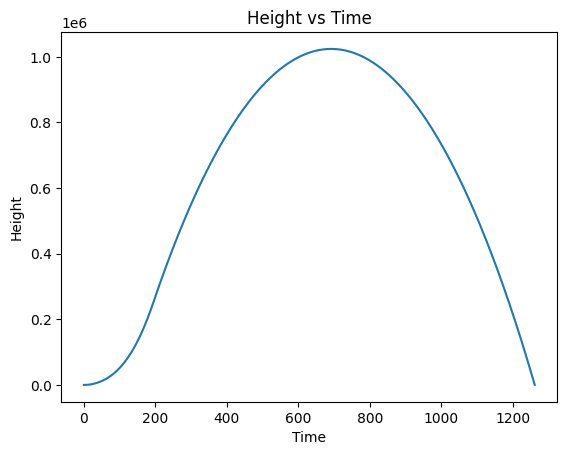

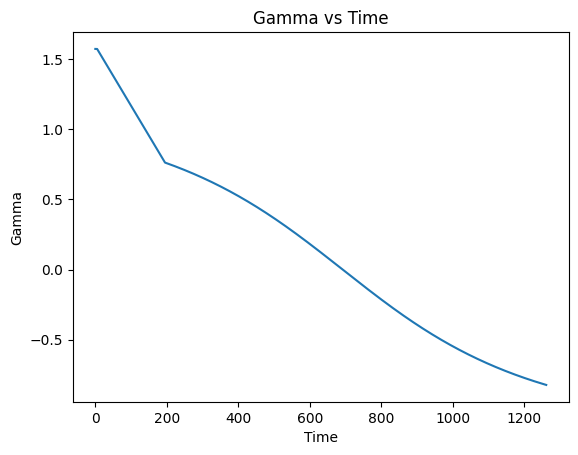

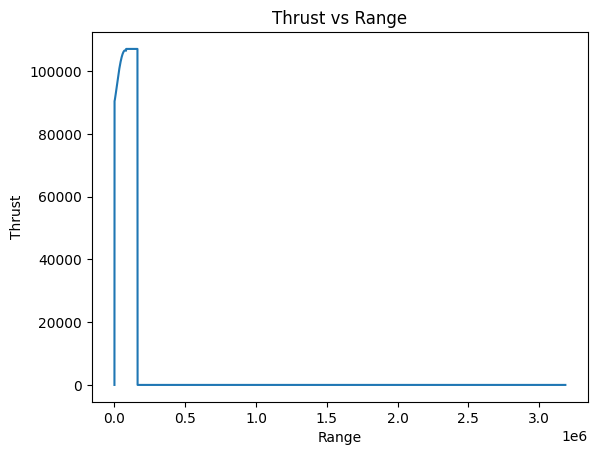

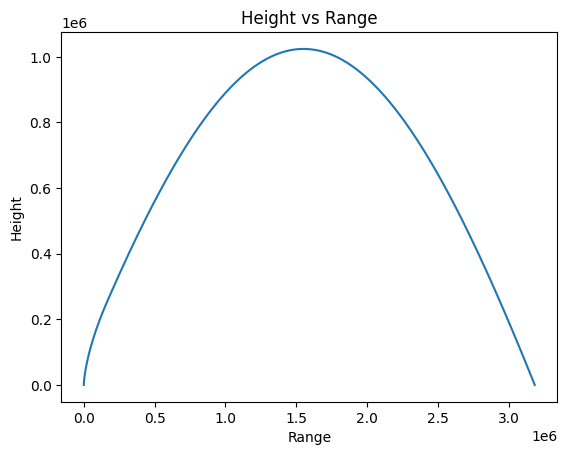

Data written to 'results/results_4.txt'

New simulation 

fuelmass: 879.211099599994
Isp0: 219.8595763167283


Stage 1 burnout
Velocity (km/s):  0.6204663957812626
Angle (deg h):  43.767244910545834
Range (km):  2.756905381762134
Time (sec):  21.100000000000033
Final results: 
Range (km):  47.18357231555982
Apogee (km):  14.90315420581485
Time to target (sec):  120.49999999999743




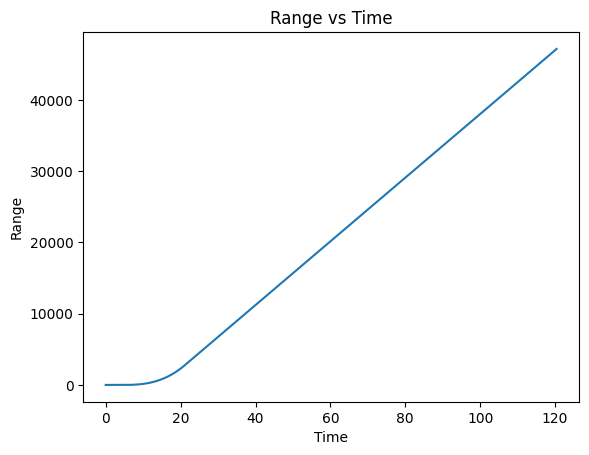

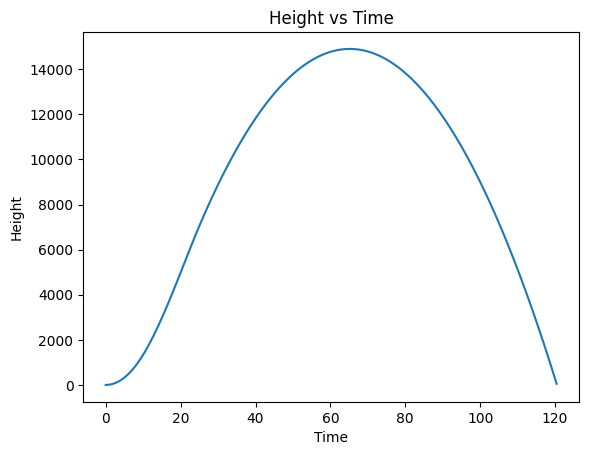

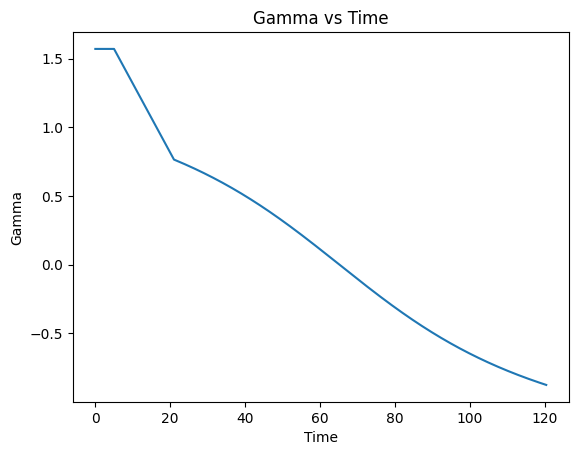

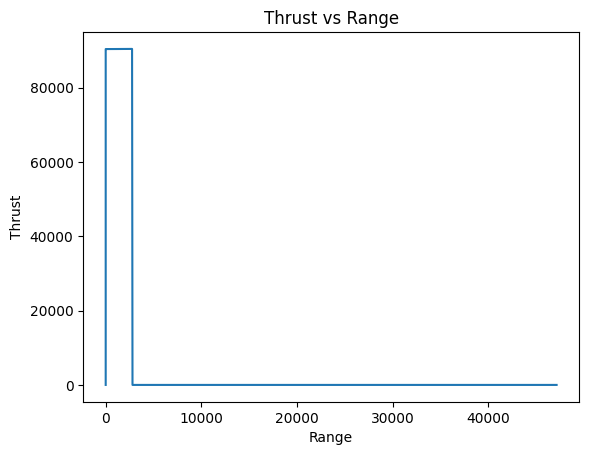

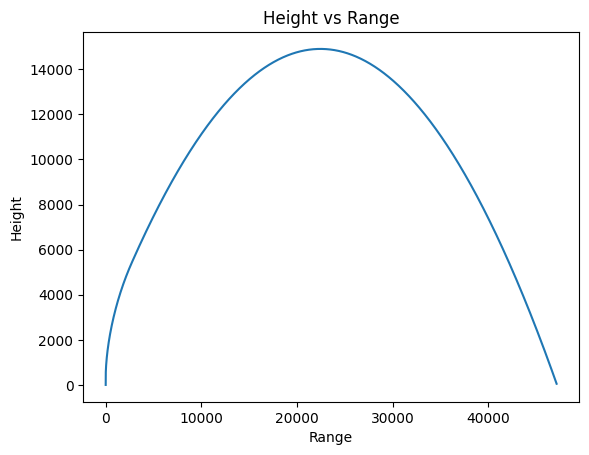

Data written to 'results/results_5.txt'


In [11]:
wirte_output_txt = True


# from emukit.core.initial_designs.latin_design import LatinDesign
# design = LatinDesign(parameter_space) 

m2_design = RandomDesign(m2_space)
m2_x = m2_design.get_samples(3*2)
m2_y = run_missile_sim(m2_x)

In [12]:
# Build model
m2_var_kernel = (100)**2 
m2_lengthscale = 100 # 100 # 1
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
m2_var_noise = 1e-5 # small value
# In catapult: 1e-5

#kern = GPy.kern.RBF(input_dim=2, lengthscale=lengthscale, variance =var_kernel)  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)

constrain_lengthscale = True

m2_rbf_kern = GPy.kern.RBF(input_dim=2, lengthscale=m2_lengthscale)
if constrain_lengthscale:
    m2_rbf_kern.lengthscale.constrain_bounded(m2_lengthscale, m2_lengthscale*1e12)

m2_kern = m2_rbf_kern + \
    GPy.kern.Linear(input_dim=2)
m2_kern = (GPy.kern.RBF(input_dim=2, lengthscale=500) * \
           GPy.kern.RBF(input_dim=2, lengthscale=100)) + \
    GPy.kern.Linear(input_dim=2)
# m2_kern = m2_rbf_kern

m2_model_gpy = GPRegression(m2_x,m2_y, kernel=m2_kern)
m2_model_gpy.kern.variance =  m2_var_kernel 
m2_model_gpy.likelihood.variance.fix(m2_var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(m2_model_gpy)




reconstraining parameters rbf.lengthscale


GP_regression.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,100.0,"100.0,100000000000000.0",
sum.linear.variances,1.0,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [13]:
# m2_model_gpy_opt = m2_model_gpy
# m2_model_gpy_opt.optimize()
# m2_model_gpy_opt.plot()

In [14]:
m2_model_emukit = GPyModelWrapper(m2_model_gpy)
m2_model_emukit.optimize()

In [15]:
display(m2_model_gpy)

GP_regression.,value,constraints,priors
sum.rbf.variance,4280945.165755043,+ve,
sum.rbf.lengthscale,100.0000000001038,"100.0,100000000000000.0",
sum.linear.variances,0.8032194108047013,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [16]:
# Create data for plot
wirte_output_txt = False
nr_points_plot = 101
m2_param_1_x_plot = np.linspace(m2_space.parameters[0].min, m2_space.parameters[0].max, nr_points_plot)[:, None]
m2_param_2_x_plot = np.linspace(m2_space.parameters[1].min, m2_space.parameters[1].max, nr_points_plot)[:, None]
m2_x_plot_mesh, m2_y_plot_mesh = np.meshgrid(m2_param_1_x_plot, m2_param_2_x_plot)
m2_x_plot = np.array([m2_x_plot_mesh, m2_y_plot_mesh]).T.reshape(-1,2)


# TEMP read data from txt
# np.savetxt('test1.txt', a, fmt='%f')
m2_y_plot = np.loadtxt('m2_y_plot.txt', dtype=float)[:,None]

if run_grid_simulation:
#     m2_y_plot = run_missile_sim(m2_x_plot) # TAKES LONG TIME    
    m2_Z = m2_y_plot.reshape(m2_x_plot_mesh.shape)




In [17]:
# Compute current prediction
m2_mu_plot_grid_pred1, var_plot_grid_pred1 = m2_model_emukit.predict(m2_x_plot)
m2_mu_plot_pred1 = m2_mu_plot_grid_pred1.reshape(m2_x_plot_mesh.shape)
m2_var_plot_pred1 = var_plot_grid_pred1.reshape(m2_x_plot_mesh.shape)

if run_grid_simulation:
    m2_rmse = evaluate_prediction(y_actual=m2_y_plot, y_predicted=m2_mu_plot_grid_pred1)
    print("RMSE m2 (before experiment design loop): ", m2_rmse)


RMSE m2 (before experiment design loop):  3203.0275119949647


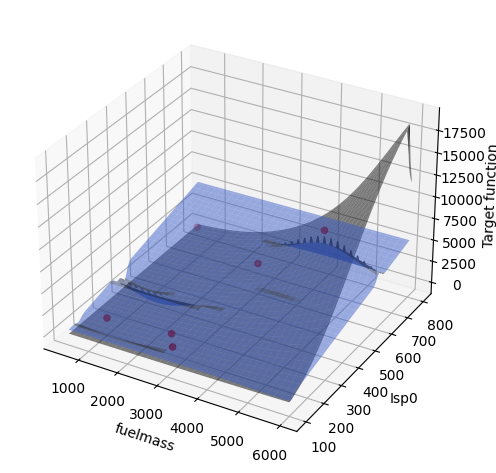

In [18]:
if run_grid_simulation:
    # 3D Plot
    add_bands = False


    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # True surface
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_Z, 
                           alpha = .5, 
                           label='target function',
                           color='black'
                          )
    # Mean predicted
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1, 
                           alpha = .5, 
                           label='model', # Mean
                           color='royalblue'
                          )
    # True points observed
    ax.scatter(m2_x[:,0], m2_x[:,1], m2_y, marker='o', color='red')

    if add_bands:
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1-2*m2_var_plot_pred1, 
                               alpha = .5, 
                               label='model_ci_lb', # Confidence band lower bound
                               color='lightskyblue'
                              )
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1+2*m2_var_plot_pred1, 
                               alpha = .5, 
                               label='model_ci_ub', # Confidence band upper bound
                               color='lightskyblue' 
                              )
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    ax.set_zlabel('Target function')
    plt.tight_layout()



 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_98744/1125577198.py:53: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_98744/1125577198.py:62: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_98744/1125577198.py:75: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


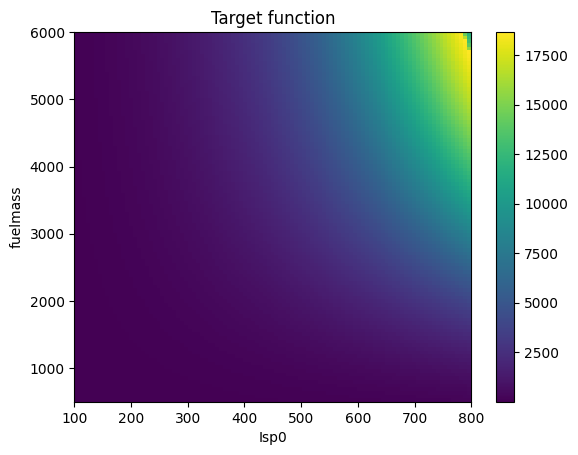

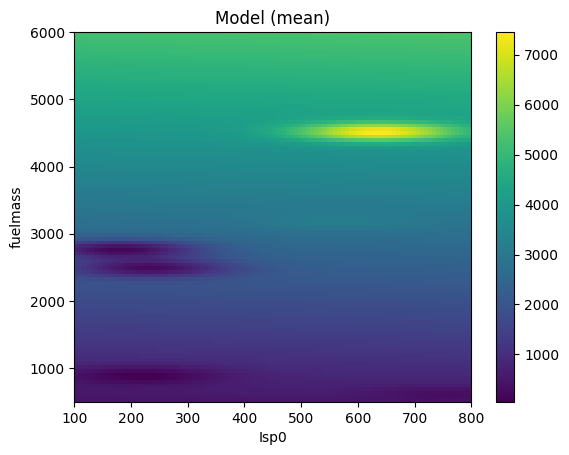

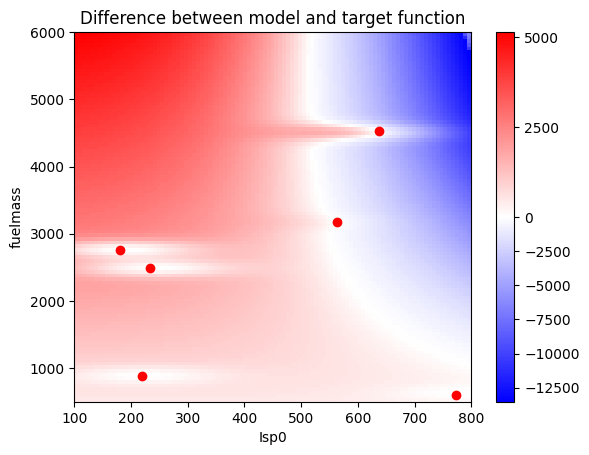

In [19]:
if run_grid_simulation:
    from matplotlib import colors
    divnorm=colors.TwoSlopeNorm(vcenter=0.) # vmin=-5., vcenter=0., vmax=10

#     # NORMAL
#     ## Heatmaps
#     extents = [m2_space.parameters[0].min, m2_space.parameters[0].max, 
#                m2_space.parameters[1].min, m2_space.parameters[1].max]

#     # True values
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_Z, extent=extents, aspect='auto')
#     ax.set_title('Target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()

#     # Model
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred1, extent=extents, aspect='auto')
#     ax.set_title('Model (mean)')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()


#     # Difference
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred1-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm)
#     ax.set_title('Difference between model and target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     # Add points where simulation evaluated
#     ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
# #     ax.plot(m2_x[:,1], m2_x[:,0], 'ro')
#     fig.colorbar(im, ax=ax)
#     fig.show()

    # REVERSE
    ## Heatmaps
    extents = [m2_space.parameters[1].min, m2_space.parameters[1].max, 
               m2_space.parameters[0].min, m2_space.parameters[0].max]

    # True values
    fig, ax = plt.subplots()
    im = ax.imshow(m2_Z, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()

    # Model
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred1, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Model (mean)')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()


    # Difference
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred1-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm, origin='lower')
    ax.set_title('Difference between model and target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    # Add points where simulation evaluated
#     ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
    ax.plot(m2_x[:,1], m2_x[:,0], 'ro')
    fig.colorbar(im, ax=ax)
    fig.show()



In [20]:
m2_x

array([[4526.4835717 ,  637.25461139],
       [2763.87728206,  180.14202828],
       [2482.94745625,  233.58315259],
       [ 600.9077029 ,  773.02671268],
       [3175.73828526,  562.38087638],
       [ 879.2110996 ,  219.85957632]])

### Use the model created for model-based experiment design
use the model to decide which are the best points to collect using some data collection criteria (that we call acquisition).

In [21]:
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance


In [22]:
# help(ExperimentalDesignLoop)

 It is known that when using Gaussian processes, selecting points of maximum variance is equivalent to maximizing the mutual information between the model and the new set of points so using ModelVariance is a simple but mathematically grounded approach.
 
 Actually in this example we use IVR

In [23]:
m2_2_model_emukit = m2_model_emukit

In [24]:
wirte_output_txt = False

integrated_variance = IntegratedVarianceReduction(space=m2_space,
                                                  model=m2_2_model_emukit)
m2_ed = ExperimentalDesignLoop(space=m2_space, 
                            model=m2_2_model_emukit, 
                            acquisition = integrated_variance,
                            batch_size = 1) 
# bach size is set to one in this example as we’ll collect evaluations 
# sequentially but parallel evaluations are allowed
m2_ed.run_loop(user_function=run_missile_sim, stopping_condition=5*2)


 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



New simulation 

fuelmass: 5858.70141168557
Isp0: 535.8768398519803


Stage 1 burnout
Velocity (km/s):  5.844208783026111
Angle (deg h):  43.66132452790439
Range (km):  298.47526316006247
Time (sec):  342.1000000000093
Final results: 
Range (km):  5790.082919948519
Apogee (km):  2056.384430646835
Time to target (sec):  2147.2999999991425



New simulation 

fuelmass: 5591.779025159833
Isp0: 328.03668201957817


Stage 1 burnout
Velocity (km/s):  3.21663461509164
Angle (deg h):  43.65796404384149
Range (km):  98.81435399754193
Time (sec):  199.89999999999293
Final results: 
Range (km):  1413.002603408367
Apogee (km):  444.6164134868128
Time to target (sec):  808.3000000001152



New simulation 

fuelmass: 5507.51341018235
Isp0: 646.6948725112948


Stage 1 burnout
Velocity (km/s):  7.084943955008753
Angle (deg h):  43.661442551914355
Range (km):  418.6414862768841
Time (sec):  388.10000000001975
Final results: 
Range (km):  9785.194572973876
Apogee (km):  4248.0616828947
Time to target (

In [25]:
m2_2_model_emukit.__dict__

{'model': <GPy.models.gp_regression.GPRegression at 0x7f78e3db1e10>,
 'n_restarts': 1}

In [26]:
m2_ed.__dict__

{'candidate_point_calculator': <emukit.core.loop.candidate_point_calculators.SequentialPointCalculator at 0x7f78e3ddb940>,
 'model_updaters': [<emukit.core.loop.model_updaters.FixedIntervalUpdater at 0x7f78e3dd9480>],
 'loop_state': <emukit.core.loop.loop_state.LoopState at 0x7f78e47418d0>,
 'loop_start_event': Event([]),
 'iteration_end_event': Event([]),
 'model': <emukit.model_wrappers.gpy_model_wrappers.GPyModelWrapper at 0x7f78e3e31e70>}

In [27]:
if run_grid_simulation:
    # Compute new prediction
    m2_mu_plot_grid_pred2, var_plot_grid_pred2 = m2_2_model_emukit.predict(m2_x_plot)
    m2_mu_plot_pred2 = m2_mu_plot_grid_pred2.reshape(m2_x_plot_mesh.shape)
    m2_var_plot_pred2 = var_plot_grid_pred2.reshape(m2_x_plot_mesh.shape)
    
    m2_2_rmse = evaluate_prediction(y_actual=m2_y_plot, y_predicted=m2_mu_plot_grid_pred2)
    print("RMSE m2 (post experiment design loop): ", m2_2_rmse)




RMSE m2 (post experiment design loop):  2692.6935022465286


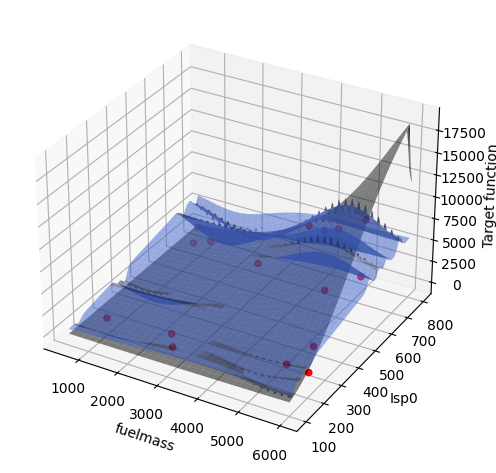

In [28]:
if run_grid_simulation:
    # 3D Plot
    add_bands = False


    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # True surface
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_Z, 
                           alpha = .5, 
                           label='target function',
                           color='black'
                          )
    # Mean predicted
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2, 
                           alpha = .5, 
                           label='model', # Mean
                           color='royalblue'
                          )
    # True points observed
    ax.scatter(np.array(m2_2_model_emukit.X)[:,0], 
               np.array(m2_2_model_emukit.X)[:,1], m2_2_model_emukit.Y, marker='o', color='red')

    if add_bands:
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2-2*m2_var_plot_pred2, 
                               alpha = .5, 
                               label='model_ci_lb', # Confidence band lower bound
                               color='lightskyblue'
                              )
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2+2*m2_var_plot_pred2, 
                               alpha = .5, 
                               label='model_ci_ub', # Confidence band upper bound
                               color='lightskyblue' 
                              )
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    ax.set_zlabel('Target function')
    plt.tight_layout()




 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_98744/3906114016.py:50: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_98744/3906114016.py:59: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_98744/3906114016.py:73: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


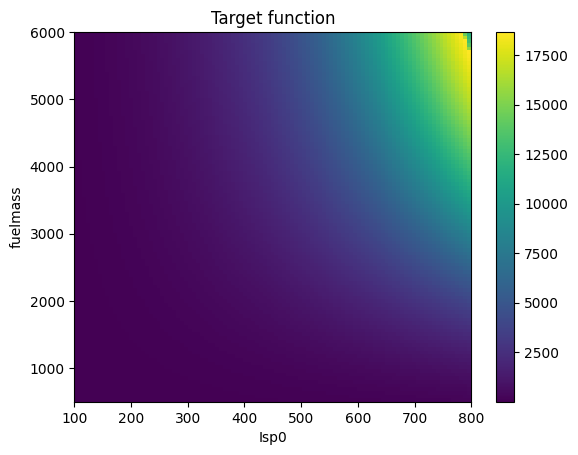

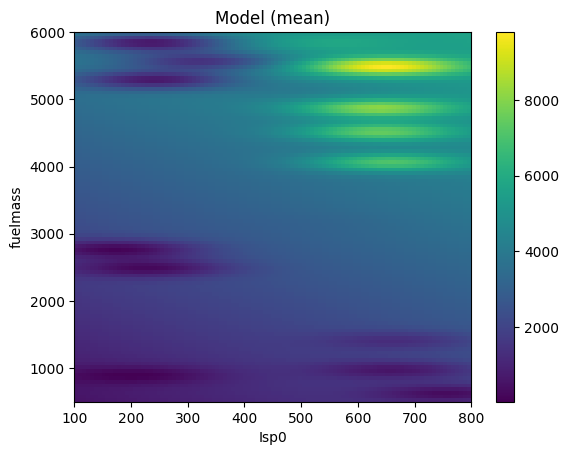

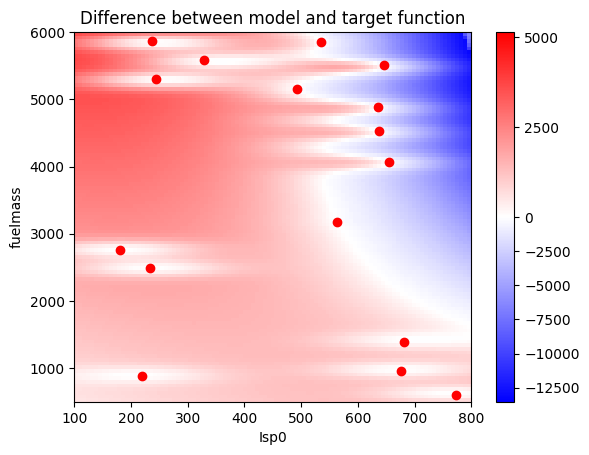

In [29]:
if run_grid_simulation:

#     ## Heatmaps
#     extents = [m2_space.parameters[0].min, m2_space.parameters[0].max, 
#                m2_space.parameters[1].min, m2_space.parameters[1].max]

#     # True values
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_Z, extent=extents, aspect='auto')
#     ax.set_title('Target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()

#     # Model
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred2, extent=extents, aspect='auto')
#     ax.set_title('Model (mean)')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()


#     # Difference
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred2-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm)
#     ax.set_title('Difference between model and target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     ax.plot(np.array(m2_2_model_emukit.X)[:,0], np.array(m2_2_model_emukit.X)[:,1], 'ro')
#     fig.colorbar(im, ax=ax)
#     fig.show()

#     # ax.plot(m2_x, m2_y, marker='o', color='red')
    
    # REVERSE
    ## Heatmaps
    extents = [m2_space.parameters[1].min, m2_space.parameters[1].max, 
               m2_space.parameters[0].min, m2_space.parameters[0].max]

    # True values
    fig, ax = plt.subplots()
    im = ax.imshow(m2_Z, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()

    # Model
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred2, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Model (mean)')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()


    # Difference
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred2-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm, origin='lower')
    ax.set_title('Difference between model and target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    # Add points where simulation evaluated
#     ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
#     ax.plot(m2_x[:,1], m2_x[:,0], 'ro')
    ax.plot(np.array(m2_2_model_emukit.X)[:,1], np.array(m2_2_model_emukit.X)[:,0], 'ro')
    fig.colorbar(im, ax=ax)
    fig.show()

